In [1]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
from scipy import stats
import re
from sklearn.linear_model import LinearRegression

In [2]:
d = pd.read_csv("../spots_annotated/spots_annotated.bed.gz", sep="\t", header=None)

In [3]:
prdm9s = ['PRDM9-A','PRDM9-B','PRDM9-C','PRDM9-D','PRDM9-E','PRDM9-F','PRDM9-G','PRDM9-H','PRDM9-I','PRDM9-J','PRDM9-K','PRDM9-L','PRDM9-M','PRDM9-N']
prdm9s = [p.split("-")[-1] for p in prdm9s]

with open("../misc_files/repeats_aboveN500.txt", "r") as fh:
    repeats = [line.strip().replace("/",".").replace(".","_").replace("-","_") for line in fh]

In [4]:
d.columns = ["scaf", "start", "end", 
             "heat", "spot", 
             "cpgi_c", "cpgi"] + sum([["{}_c".format(p),p] for p in prdm9s], []) + sum([["{}_c".format(p),p] for p in repeats], [])

In [6]:
abundant_repeats = d[repeats].mean().sort_values().index[-20:]
fam_prdm9 = ["I", "G", "M", "J"]

In [182]:
mods = {}
master_fd = pd.DataFrame()
indep = "+".join(["{}".format(p) for p in abundant_repeats])

for p in fam_prdm9:
    subd = d[(d.cpgi==0) & (d[p]>0)]
    #### NORMALITZATION
    #df = subd[abundant_repeats]
    #norm_df = (df-df.min())/(df.max()-df.min())
    #norm_df["spot"] = subd["spot"]
    #subd = norm_df
    ####
    mods[p] = smf.logit("spot ~ {}".format(indep), data=subd).fit()
    print(p, len(subd))
    print(mods[p].summary())
    fold_diff = subd.groupby("spot")[abundant_repeats].mean().transpose().reset_index()
    fold_diff.columns = ["repeat", "coldspot", "hotspot"]
    fold_diff["fold_diff"] = fold_diff.coldspot/fold_diff.hotspot
    fold_diff["prdm9"] = p
    master_fd = pd.concat([master_fd, fold_diff])

Optimization terminated successfully.
         Current function value: 0.633378
         Iterations 8
I 1857
                           Logit Regression Results                           
Dep. Variable:                   spot   No. Observations:                 1857
Model:                          Logit   Df Residuals:                     1836
Method:                           MLE   Df Model:                           20
Date:                Wed, 09 Nov 2022   Pseudo R-squ.:                 0.07660
Time:                        11:20:39   Log-Likelihood:                -1176.2
converged:                       True   LL-Null:                       -1273.8
Covariance Type:            nonrobust   LLR p-value:                 1.028e-30
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6665      0.112      5.953      0.000       0.447       0.886
L

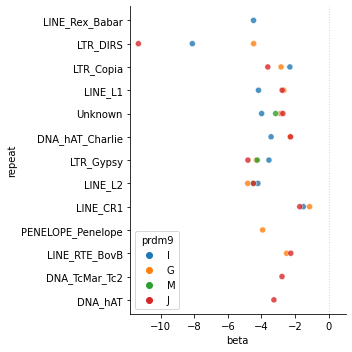

In [194]:
df_l = []
for p in mods:
    df = pd.DataFrame([mods[p].params, mods[p].pvalues])
    df.index = ["beta", "pval"]
    df = df.transpose()
    df = df[df.pval<0.05]
    df = df["beta"].reset_index()
    df["prdm9"] = p
    df_l.append(df)
    
flat_betas = pd.concat(df_l)
flat_betas.columns = ["repeat", "beta", "prdm9"]

f,ax = plt.subplots(figsize=[5,5])
sns.scatterplot(data=flat_betas[flat_betas.repeat!="Intercept"], 
                y="repeat", 
                x="beta", 
                hue="prdm9",
                ax=ax, 
                alpha=0.8)
ax.set_xlim(right=1)
ax.axvline(x=0, 
           linestyle="dotted", 
           linewidth=1,
           color="lightgray")
sns.despine()
plt.tight_layout()
plt.savefig("pdfs/betas.pdf")

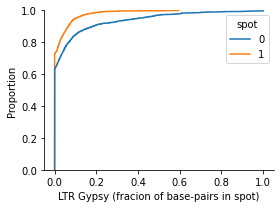

In [199]:
f,ax = plt.subplots(figsize=[4,3])
sns.ecdfplot(data=subd, x="LTR_Gypsy", hue="spot")
ax.set_xlabel("LTR Gypsy (fracion of base-pairs in spot)")
sns.despine()
plt.tight_layout()
plt.savefig("pdfs/gypsy.pdf")

<AxesSubplot:xlabel='spot', ylabel='LTR_DIRS'>

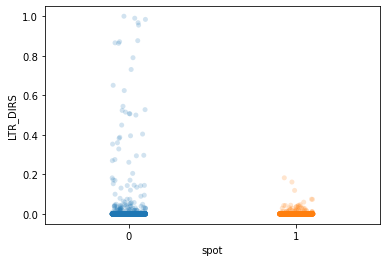

In [83]:
sns.stripplot(data=subd,x="spot",y="LTR_DIRS", alpha=0.2)

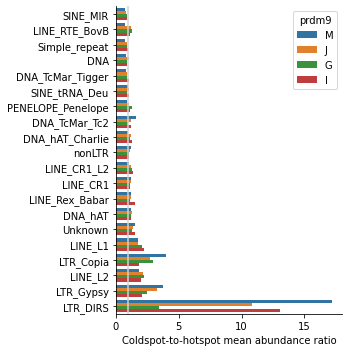

In [204]:
f,ax = plt.subplots(figsize=[5,5])
sns.barplot(data=master_fd.sort_values(by="fold_diff"), 
            x="fold_diff", 
            y="repeat", 
            hue="prdm9",
            ax=ax)
ax.set_xlabel("Coldspot-to-hotspot mean abundance ratio")
ax.set_ylabel("")
ax.axvline(x=1, color="lightgray")
sns.despine()
plt.tight_layout()
plt.savefig("pdfs/fold_differences.pdf")